In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-12-28 07:06:06.378661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 07:06:06.378776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 07:06:06.505934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [4]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [5]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False,  # No shuffling needed for testing
    seed = 42
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [6]:
IMAGE_SIZE = [224, 224]

# EfficientNetB3

In [7]:
from tensorflow.keras.applications import EfficientNetB3

In [8]:
enb3 = EfficientNetB3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb3.layers:
        layer.trainable = False


flatten = Flatten()(enb3.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

efnetB3 = Model(inputs=enb3.input, outputs=prediction)
efnetB3.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 30,084,658 (114.76 MB)

 Trainable params: 19,301,123 (73.63 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [9]:
efnetB3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
batch_size = 128

# EfficientNetB3 Training

In [11]:
history = efnetB3.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1735369742.728448     137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1735369742.812011     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/94 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.5374 - loss: 7.7350  

W0000 00:00:1735369820.779150     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6451 - loss: 5.8266

W0000 00:00:1735369850.771517     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.6467 - loss: 5.7959 - val_accuracy: 0.9320 - val_loss: 0.3299
Epoch 2/5


W0000 00:00:1735369880.434701     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.9442 - loss: 0.3082 - val_accuracy: 0.9007 - val_loss: 0.5197
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 574ms/step - accuracy: 0.8800 - loss: 0.8515 - val_accuracy: 0.9220 - val_loss: 0.3298
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 565ms/step - accuracy: 0.9593 - loss: 0.1718 - val_accuracy: 0.9813 - val_loss: 0.0560
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 568ms/step - accuracy: 0.9811 - loss: 0.0498 - val_accuracy: 0.9793 - val_loss: 0.0558


In [12]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()


In [13]:
def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [15]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [16]:
def report_accracy(model, test_set):

    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = confusion_matrix(test_set.classes, y_pred)
    report = classification_report(test_set.classes, y_pred, output_dict=True)
    overall_accuracy = report['accuracy']
    
    return overall_accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 530ms/step - accuracy: 0.9921 - loss: 0.0248
test_loss, test accuracy [0.04607100412249565, 0.984666645526886]


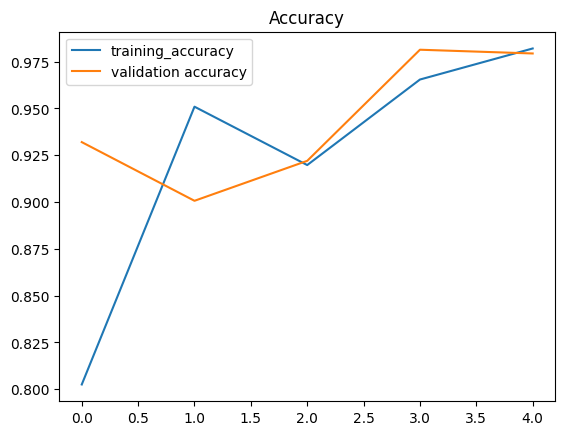

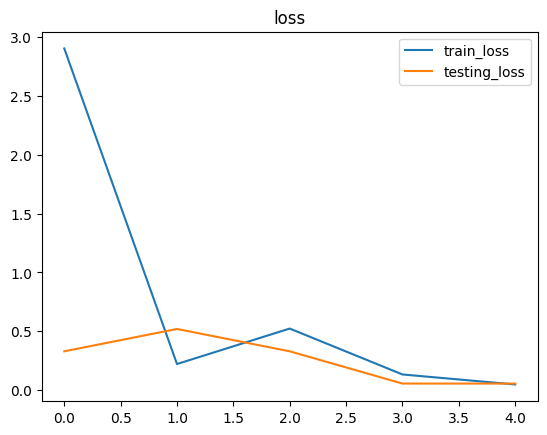

 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:41 9s/step

W0000 00:00:1735370128.207806     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 
Confusion Matrix
[[497   2   1]
 [  1 499   0]
 [ 19   0 481]]
Classification Report
              precision    recall  f1-score   support

         aca       0.96      0.99      0.98       500
           n       1.00      1.00      1.00       500
         scc       1.00      0.96      0.98       500

    accuracy                           0.98      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.98      0.98      1500



W0000 00:00:1735370141.836716     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
result = efnetB3.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

accuracy_curve(history)
loss_curve(history)
reports(efnetB3,test_set)

In [18]:
r_accuracy = report_accracy(efnetB3,test_set) * 100
formatted_accuracy = f"{r_accuracy:.2f}"
print(formatted_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step
98.47


# Knowledge Distillation

In [19]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np
import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras import layers, models, optimizers, losses

In [20]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.3,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

# Model 1 KD

In [21]:
from tensorflow.keras.utils import to_categorical  # Import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
model_1_kd = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)

model_1_kd.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
data = []
temperatures = [5,16,31,46,57,69,78,86,93,99]

Epoch 1/10


W0000 00:00:1735370194.512482     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370194.515742     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370215.348278     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370275.696231     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370275.730342     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370290.664280     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 527ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 532ms/step - accuracy: 0.8289 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8846666812896729, 0.8846666812896729]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step
Confusion Matrix
[[376   6 118]
 [  7 493   0]
 [ 42   0 458]]
Classification Report
              precision    recall  f1-score   support

         aca       0.88      0.75      0.81       500
           n       0.99      0.99      0.99       500
         scc       0.80      0.92      0.85       500

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.89      0.88      0.88      1500

Epoch 1/10


W0000 00:00:1735370882.750115     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370882.754837     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370903.849027     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370949.346259     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735370949.378958     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1735370959.720057     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.8722 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.699999988079071, 0.699999988079071]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step
Confusion Matrix
[[473  15  12]
 [ 12 488   0]
 [408   3  89]]
Classification Report
              precision    recall  f1-score   support

         aca       0.53      0.95      0.68       500
           n       0.96      0.98      0.97       500
         scc       0.88      0.18      0.30       500

    accuracy                           0.70      1500
   macro avg       0.79      0.70      0.65      1500
weighted avg       0.79      0.70      0.65      1500

Epoch 1/10


W0000 00:00:1735371551.469566     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735371551.472635     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735371590.281331     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735371616.239022     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735371616.271721     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735371626.525435     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 508ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step - accuracy: 0.8426 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8886666893959045, 0.8886666893959045]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step
Confusion Matrix
[[392   8 100]
 [ 11 489   0]
 [ 48   0 452]]
Classification Report
              precision    recall  f1-score   support

         aca       0.87      0.78      0.82       500
           n       0.98      0.98      0.98       500
         scc       0.82      0.90      0.86       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500

Epoch 1/10


W0000 00:00:1735372214.755879     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372214.758470     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372227.411214     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372278.312462     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372278.346059     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372288.451635     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.7829 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8586666584014893, 0.8586666584014893]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step
Confusion Matrix
[[342   6 152]
 [ 14 484   2]
 [ 38   0 462]]
Classification Report
              precision    recall  f1-score   support

         aca       0.87      0.68      0.77       500
           n       0.99      0.97      0.98       500
         scc       0.75      0.92      0.83       500

    accuracy                           0.86      1500
   macro avg       0.87      0.86      0.86      1500
weighted avg       0.87      0.86      0.86      1500

Epoch 1/10


W0000 00:00:1735372877.603092     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372877.605745     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372930.633774     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372943.166851     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735372943.199667     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1735372953.271375     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 515ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.7353 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8473333120346069, 0.8473333120346069]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step
Confusion Matrix
[[305   8 187]
 [  8 492   0]
 [ 26   0 474]]
Classification Report
              precision    recall  f1-score   support

         aca       0.90      0.61      0.73       500
           n       0.98      0.98      0.98       500
         scc       0.72      0.95      0.82       500

    accuracy                           0.85      1500
   macro avg       0.87      0.85      0.84      1500
weighted avg       0.87      0.85      0.84      1500

Epoch 1/10


W0000 00:00:1735373542.189571     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735373542.192274     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735373550.040878     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735373606.718215     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735373606.753871     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735373617.044791     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.8215 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.878000020980835, 0.878000020980835]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step
Confusion Matrix
[[374   6 120]
 [ 13 487   0]
 [ 44   0 456]]
Classification Report
              precision    recall  f1-score   support

         aca       0.87      0.75      0.80       500
           n       0.99      0.97      0.98       500
         scc       0.79      0.91      0.85       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500

Epoch 1/10


W0000 00:00:1735374210.679275     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374210.681867     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374221.123149     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374276.991484     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374277.025301     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374287.337150     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.8936 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8706666827201843, 0.8706666827201843]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step
Confusion Matrix
[[440   7  53]
 [  2 498   0]
 [132   0 368]]
Classification Report
              precision    recall  f1-score   support

         aca       0.77      0.88      0.82       500
           n       0.99      1.00      0.99       500
         scc       0.87      0.74      0.80       500

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500

Epoch 1/10


W0000 00:00:1735374875.012504     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374875.015088     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374903.774979     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374941.282237     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735374941.315980     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1735374951.522159     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.7947 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8726666569709778, 0.8726666569709778]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step
Confusion Matrix
[[349   4 147]
 [  7 492   1]
 [ 32   0 468]]
Classification Report
              precision    recall  f1-score   support

         aca       0.90      0.70      0.79       500
           n       0.99      0.98      0.99       500
         scc       0.76      0.94      0.84       500

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500

Epoch 1/10


W0000 00:00:1735375542.297178     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735375542.299825     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735375554.605434     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735375607.485033     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735375607.516845     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735375617.825891     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 527ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - accuracy: 0.6244 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8040000200271606, 0.8040000200271606]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step
Confusion Matrix
[[215   9 276]
 [  3 495   2]
 [  4   0 496]]
Classification Report
              precision    recall  f1-score   support

         aca       0.97      0.43      0.60       500
           n       0.98      0.99      0.99       500
         scc       0.64      0.99      0.78       500

    accuracy                           0.80      1500
   macro avg       0.86      0.80      0.79      1500
weighted avg       0.86      0.80      0.79      1500

Epoch 1/10


W0000 00:00:1735376209.429335     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735376209.432315     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735376239.884095     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735376274.936575     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735376274.968544     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1735376285.304927     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - accuracy: 0.8862 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.903333306312561, 0.903333306312561]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step
Confusion Matrix
[[426   7  67]
 [  2 498   0]
 [ 69   0 431]]
Classification Report
              precision    recall  f1-score   support

         aca       0.86      0.85      0.85       500
           n       0.99      1.00      0.99       500
         scc       0.87      0.86      0.86       500

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



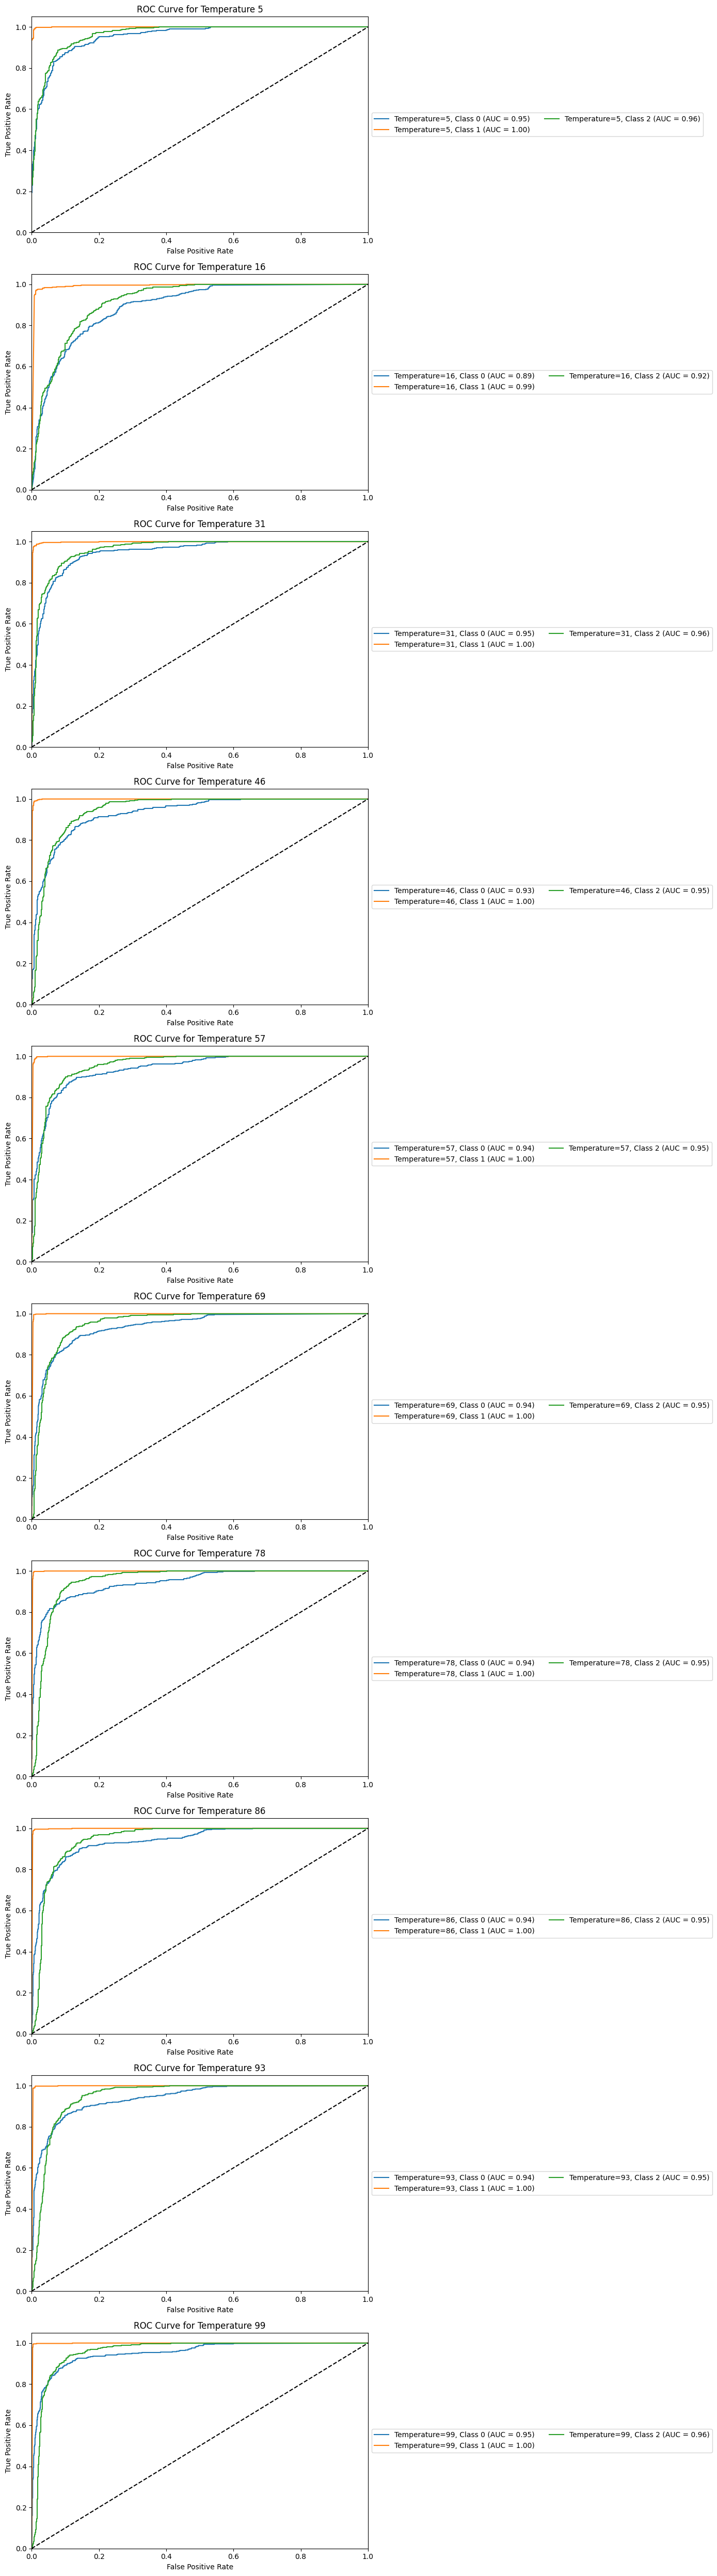

In [24]:
# Initialize a figure with subplots for each temperature
fig, axes = plt.subplots(len(temperatures), 1, figsize=(14, len(temperatures) * 5))

for idx, i in enumerate(temperatures):
    ax = axes[idx]  # Select the subplot for the current temperature

    distiller_model1 = Distiller(student=model_1_kd, teacher=efnetB3)
    distiller_model1.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.4,
        temperature=i
    )
    # Training with KD
    history_model1 = distiller_model1.fit(train_set, validation_data=validate_set, epochs=10, verbose=4)

    # Predict probabilities on the test set
    y_pred_probs = distiller_model1.predict(test_set)
    
    # Extract the true labels from the test set
    y_true = test_set.labels
    
    # Check if y_true is one-hot encoded or not
    if len(y_true.shape) == 1:  # Not one-hot encoded, single-class labels
        n_classes = np.max(y_true) + 1  # Determine number of classes
        y_true = to_categorical(y_true, num_classes=n_classes)
    else:
        n_classes = y_true.shape[1]

    # Convert probabilities to predicted classes
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_true[:, j], y_pred_probs[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])
    
    # Plot ROC curve for each class on the same subplot
    for j in range(n_classes):
        ax.plot(fpr[j], tpr[j], label=f'Temperature={i}, Class {j} (AUC = {roc_auc[j]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Temperature {i}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)  # Adjust legend position

    # Calculate accuracy, precision, recall, and F1 score
    r_accuracy = report_accracy(distiller_model1, test_set) * 100
    formatted_accuracy = f"{r_accuracy:.2f}"

    precision = precision_score(y_true_classes, y_pred_classes, average='weighted') * 100
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted') * 100
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted') * 100
    
    # Format precision, recall, and f1 score to 2 decimal places
    formatted_precision = f"{precision:.2f}"
    formatted_recall = f"{recall:.2f}"
    formatted_f1 = f"{f1:.2f}"

    # Append the data to the list
    data.append(
        {
            "Alpha": 0.4,
            "Temperature": i,
            "Accuracy": formatted_accuracy,
            "Precision": formatted_precision,
            "Recall": formatted_recall,
            "F1 Score": formatted_f1
        }
    )
    
    result = distiller_model1.evaluate(test_set, batch_size=128)
    print("test_loss, test accuracy", result)

    reports(distiller_model1, test_set)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all subplots
plt.show()

# Model 1 KD Evaluation

In [25]:
results_df = pd.DataFrame(data)
results_df

,Alpha,Temperature,Accuracy,Precision,Recall,F1 Score
0,0.4,5,88.47,88.93,88.47,88.38
1,0.4,16,70.00,79.18,70.00,64.85
2,0.4,31,88.87,89.06,88.87,88.82
3,0.4,46,85.87,86.86,85.87,85.69
4,0.4,57,84.73,86.69,84.73,84.25
5,0.4,69,87.80,88.24,87.80,87.73
6,0.4,78,87.07,87.56,87.07,86.98
7,0.4,86,87.27,88.37,87.27,87.09
8,0.4,93,80.40,86.38,80.40,78.68
9,0.4,99,90.33,90.29,90.33,90.31
